In [71]:
# function definitions are in the script, no definitions in this ipynb allowed!
include("PES_models_bonding_features.jl") # need to reload everytime a change occurs
include("RATPOT.jl")
using DataFrames, CSV

In [92]:
# test using actual data:
H_data = readdlm("data/h3/h3_data.txt")
# load atomic coordinates:
H_coord = npzread("data/h3/h3_coord.npy")
R = H_data[:,1:end-1]; V = H_data[:, end]
n_data = size(R)[1]

6032

In [93]:
idxes = shuffleobs(1:n_data); # shuffle indexes

In [94]:
# split:
id_train, id_test = splitobs(idxes, at=0.8)
R_train = R[id_train,:]; V_train = V[id_train];
R_test = R[id_test,:]; V_test = V[id_test]
H_coord_train = H_coord[id_train,:,:]; H_coord_test = H_coord[id_test,:,:];

In [95]:
const_r_xy = 1.4172946 # H2
e_pow = 3
#const_r_xy = 1.9369 #OH+
N = 2 # hyperparam
ρ = f_ρ(R, const_r_xy)
q = f_q_bump(N, ρ)
i = f_i(q) # should be transformed to unique integers
ϵ = f_ϵ(i, q)
# for h:
α = f_α(ϵ)
β = f_β(ϵ)
ub = 1.; lb = -1; θ = rand(2*N+2) .* (ub-lb) .+ lb; # +2 since it starts from 0th index
θ = ones(2*N+2);

In [96]:
n_data, n_d = size(R)
u = similar(R)
w = similar(u)
h = zeros(n_data, n_d, N+1) #stores the first sub primitive
compute_u_w_h!(u, w, h, θ, q, α, β, i, N)
#@benchmark compute_u_w_h!($u, $w, $h, $θ, $q, $α, $β, $i, $N)

In [97]:
x = similar(h)
y = similar(x)
compute_hw_gw!(x, y, w, h, q, N)
#@benchmark compute_hw_gw!($x, $y, $w, $h, $q, $N)

In [98]:
ρ,u,w,x,y = BUMP_feature(θ, R, const_r_xy, N);
#@benchmark BUMP_feature($θ, $R, $const_r_xy, $N)

In [99]:
b = concat_BUMP(x, y, 5);
#@benchmark concat_BUMP($x, $y, 5)

In [100]:
idxer = atom_indexer(3)
U = f_U_bas_BUMP(idxer, u, w, ρ, e_pow);
#@benchmark f_U_bas_BUMP($idxer, $u, $w, $ρ, $e_pow)

In [101]:
Y = f_Y_coord(b, idxer);
#@benchmark f_Y_coord($b, $idxer)

In [16]:
@benchmark Y ./ maximum(abs.(Y))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  118.800 μs …   1.878 ms  ┊ GC (min … max):  0.00% … 90.44%
 Time  (median):     133.900 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   165.837 μs ± 179.053 μs  ┊ GC (mean ± σ):  15.18% ± 12.53%

  █▆▄▂                                                          ▁
  █████▆▅▃▄▄▅▆▆▄▅▄▄▃▃▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆██ █
  119 μs        Histogram: log(frequency) by time       1.34 ms <

 Memory estimate: 1.38 MiB, allocs estimate: 9.

In [102]:
Δ = f_Δcoord(H_coord);
#@benchmark f_Δcoord($H_coord)

In [103]:
rk = f_r_orient_vec(b, Δ, idxer)
display(rk)
@benchmark f_r_orient_vec($b, $Δ, $idxer)

3×6032×5×3 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0          …   8.12433e-23   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  -0.000108169     -0.345578     -0.343816
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.000239232      6.71815       6.52541

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0          …   2.45978e-23   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  -0.000105103     -0.104629     -0.10593
 0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.00023245       2.03403       2.01049

[:, :, 3, 1] =
 -3.28516e-24   4.0231e-25  0.0          …   1.89705e-22   0.0
 -1.69901      -1.63856     2.02697         -0.755142     -0.777539
  1.0393        1.28038     1.11022e-16      0.942994      1.16941

[:, :, 4, 1] =
 -2.7705e-25   1.00302e-25  0.0          …   3.54174e-23   0.0
 -0.162857    -0.140156     0.168285        -0.137135     -0.148556
  0.0363234    0.00719732   1.38778e-17     -0.919438     -0.88365

[:, :, 5, 1] =
 -2.35649e-26   1.12807e-26  0.0          …   

BenchmarkTools.Trial: 1702 samples with 1 evaluation.
 Range (min … max):  2.425 ms …   6.997 ms  ┊ GC (min … max): 0.00% … 48.55%
 Time  (median):     2.548 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.917 ms ± 853.782 μs  ┊ GC (mean ± σ):  9.08% ± 14.97%

  ▄█▆▃▁▁ ▁    ▁                            ▃▂                  
  █████████████████▇▆▆▆▄▅▃▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▅██▇▅▅▄▅▃▅▃▁▃▁▁▄▄▄▅ █
  2.43 ms      Histogram: log(frequency) by time      6.18 ms <

 Memory estimate: 8.70 MiB, allocs estimate: 57.

In [19]:
@benchmark rk ./ maximum(abs.(rk))

BenchmarkTools.Trial: 3684 samples with 1 evaluation.
 Range (min … max):  769.400 μs … 11.248 ms  ┊ GC (min … max):  0.00% …  0.00%
 Time  (median):       1.067 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):     1.354 ms ±  1.249 ms  ┊ GC (mean ± σ):  22.22% ± 19.47%

  ▇█▇█▅▄▅▁                                         ▁▂▁         ▁
  ████████▆▃▄▄▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▇█████▇▆▆▅▆▅▆▅ █
  769 μs        Histogram: log(frequency) by time      6.89 ms <

 Memory estimate: 4.14 MiB, allocs estimate: 11.

In [23]:
G = f_G_mat(rk)
@benchmark f_G_mat($rk)

BenchmarkTools.Trial: 1367 samples with 1 evaluation.
 Range (min … max):  2.961 ms … 10.965 ms  ┊ GC (min … max):  0.00% … 65.72%
 Time  (median):     3.163 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.654 ms ±  1.067 ms  ┊ GC (mean ± σ):  13.01% ± 17.50%

  ▂▇█▇▅▄▂                               ▁▁▂▃▂▁ ▁              
  ███████▇▆▅▅▅▅▁▄▅▁▄▄▁▁▄▁▁▄▁▄▄▁▁▄▅▅▁▁▁▁▄████████▆▆▆▇▇▆▅▅▅▁▄▅ █
  2.96 ms      Histogram: log(frequency) by time     6.73 ms <

 Memory estimate: 13.12 MiB, allocs estimate: 153.

In [206]:
Φ = f_Φ(U, Y, G, 59)
@benchmark f_Φ($U, $Y, $G, 59)

BenchmarkTools.Trial: 2144 samples with 1 evaluation.
 Range (min … max):  1.139 ms … 16.316 ms  ┊ GC (min … max):  0.00% … 60.67%
 Time  (median):     1.850 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.329 ms ±  2.125 ms  ┊ GC (mean ± σ):  21.69% ± 19.08%

     █▃▁                                                      
  ▄▃▃███▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▂▃▂ ▂
  1.14 ms        Histogram: frequency by time        11.3 ms <

 Memory estimate: 8.15 MiB, allocs estimate: 2.

In [328]:
#tchebyshev:
C, R_h, R_low, R_0, R_m,R_up, R_C = (1., 0.01, 0.02, 0.5, .9, 10., 11.)
ub = 1.; lb = -1.
#C, R_h, R_low, R_0, R_m,R_up, R_C = rand(7).* (ub-lb) .+ lb;
n_atom, n_basis, g, e = (3, 59, 6, 3)
r_xy, N, max_deg = (1.4172946, 5, 5)
U = f_U_bas(R, idxer, C, R_h, R_C, R_0, g)
println("U ",mean(U), " ", minimum(U), " ", maximum(U)," ", std(U))
b = f_b_feature(R, R_up, R_m, R_low, max_deg, e)
println("b ",mean(b), " ", minimum(b), " ", maximum(b)," ", std(b))
Y = f_Y_coord(b, idxer)
println("Y ",mean(Y), " ", minimum(Y), " ", maximum(Y)," ", std(Y))
Δ = f_Δcoord(H_coord)
rk = f_r_orient_vec(b, Δ, idxer)
println("rk ",mean(rk), " ", minimum(rk), " ", maximum(rk)," ", std(rk))
G = f_G_mat(rk)
println("G ",mean(G), " ", minimum(G), " ", maximum(G)," ", std(G))
Φ = f_Φ(U, Y, G, n_basis)
println("Φ ", mean(Φ), " ", minimum(Φ), " ", maximum(Φ)," ", std(Φ))

U -0.5797520405478458 -1.0 0.0 0.2900095253731425
b 0.01701748041385712 -0.25 0.76041202189571 0.059169315456611256
Y 0.03403496082771424 -0.3832001580107737 0.7611893352040209 0.08443718931310261
rk -0.008908869062954163 -0.5636557216268155 0.5367028157760589 0.0525513751194236
G 0.004023272507118442 -0.1428144911012107 0.3194900981574427 0.018029137279815796
Φ -0.008275105587526695 -1.0 0.7611893352040209 0.09293407838228224


In [358]:
#BUMP:
# hyperparam:
N = 2; max_deg = 5; e_pow = 3; n_basis = 59; const_r_xy = 1.4172946; 
ub = 1.; lb = -1.; θ = rand(2*N+2) .* (ub-lb) .+ lb;
Θ = rand(n_basis, 6) .* (ub-lb) .+ lb;
ρ,u,w,x,y = BUMP_feature(θ, R, const_r_xy, N);
U = f_U_bas_BUMP(idxer, u, w, ρ, e_pow)
println("U ",mean(U), " ", minimum(U), " ", maximum(U)," ", std(U))
b = concat_BUMP(x, y, max_deg);
println("b ",mean(b), " ", minimum(b), " ", maximum(b)," ", std(b))
Y = f_Y_coord(b, idxer)
Y = Y ./ maximum(abs.(Y))
println("Y ",mean(Y), " ", minimum(Y), " ", maximum(Y)," ", std(Y))
Δ = f_Δcoord(H_coord)
rk = f_r_orient_vec(b, Δ, idxer)
rk = rk ./ maximum(abs.(rk))
println("rk ",mean(rk), " ", minimum(rk), " ", maximum(rk)," ", std(rk))
G = f_G_mat(rk)
#G = G ./ maximum(abs.(G))
println("G ",mean(G), " ", minimum(G), " ", maximum(G)," ", std(G))
Φ = f_Φ(U, Y, G, n_basis)
#Φ = Φ./maximum(abs.(Φ))
println("Φ ",mean(Φ), " ", minimum(Φ), " ", maximum(Φ)," ", std(Φ))

U 0.17446762098153076 -1.0 0.6645603457001372 0.17504937067490542
b 0.19917250000016573 -0.27741450205575025 0.9999999999971216 0.3512228536714614
Y 0.19917268302859983 -0.2773363656679622 1.0 0.32475124560286583
rk 0.009894944977976943 -0.958809741264912 1.0 0.07816680420165806
G 0.005252716778684095 -0.03597578058302146 1.000027646724492 0.037276237975188094
Φ 0.04822399163953965 -1.0 1.0000552942133254 0.14208278850915093


In [326]:
@btime rk ./ maximum(abs.(rk));
@btime Y ./ maximum(abs.(Y));
@btime G ./ maximum(abs.(G));
@btime Φ./maximum(abs.(Φ));

  754.900 μs (11 allocations: 4.14 MiB)
  91.500 μs (9 allocations: 1.38 MiB)
  912.600 μs (11 allocations: 6.90 MiB)
  2.397 ms (9 allocations: 16.29 MiB)


6032×59×3 Array{Float64, 3}:
[:, :, 1] =
  1.12042e-6  0.0          0.0         0.0         …   0.0         0.0
  9.97653e-7  0.0          0.0         0.0             0.0         0.0
  1.09305e-6  0.0          0.0         0.0             0.0         0.0
  1.09305e-6  0.0          0.0         0.0             0.0         0.0
  9.40725e-7  0.0          0.0         0.0             0.0         0.0
  9.40725e-7  0.0          0.0         0.0         …   0.0         0.0
  8.17953e-7  0.0          0.0         0.0             0.0         0.0
  7.23381e-7  0.0          0.0         0.0             0.0         0.0
  7.88398e-7  0.0          0.0         0.0             0.0         0.0
  7.88398e-7  0.0          0.0         0.0             0.0         0.0
  7.88398e-7  0.0          0.0         0.0         …   0.0         0.0
  6.65625e-7  0.0          0.0         0.0             0.0         0.0
  6.65625e-7  0.0          0.0         0.0             0.0         0.0
  ⋮                                 

#### BUMP feval

In [110]:
idxer = atom_indexer(3)
N = 2; max_deg = 5; e_pow = 3; n_basis = 59; const_r_xy = 1.4172946; 
ub = 1.; lb = -1.; θ = rand(2*N+2) .* (ub-lb) .+ lb;
Θ = rand(n_basis, 6) .* (ub-lb) .+ lb;
#θ = ones(2*N+2); Θ = ones(n_basis, 6)
V = f_pot_bond_BUMP(θ, Θ, R, H_coord, idxer, const_r_xy, n_basis, N, e_pow, max_deg)
display(V)
@benchmark f_pot_bond_BUMP($θ, $Θ, $R, $H_coord, $idxer, $const_r_xy, $n_basis, $N, $e_pow, $max_deg)

6032×1 Matrix{Float64}:
 -2.385869950461983
 -2.2419096769163027
 -2.4169649098330575
 -2.363877251859399
 -2.248498785447651
 -2.2011502842397483
 -2.068242657092144
 -1.9590744869815704
 -2.143848015770923
 -2.093224299815498
 -2.0502984307054266
 -1.9655843618475477
 -1.927146184810168
  ⋮
  0.7106511967721443
  0.8564314339999948
  0.7021494509592494
  0.7290603387734549
  0.4124924043987376
  0.3936862320067372
  0.42791731729153915
  0.3950353203550351
  0.39226258386235663
  0.37993261932889155
  0.4073898169060772
  0.3854352240945597

BenchmarkTools.Trial: 322 samples with 1 evaluation.
 Range (min … max):  12.703 ms … 59.738 ms  ┊ GC (min … max): 0.00% … 6.77%
 Time  (median):     15.805 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.510 ms ±  3.879 ms  ┊ GC (mean ± σ):  9.57% ± 9.00%

  █▃▂▃▂ ▁   ▇▆▁▃                                               
  █████▆█▆▁▆█████▇███▄▆▆▄▆▄▁▄▄▄▁▁▄▁▄▁▁▁▁▄▁▁▄▄▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▄ ▆
  12.7 ms      Histogram: log(frequency) by time        30 ms <

 Memory estimate: 44.10 MiB, allocs estimate: 414.

In [116]:
Θ_vec = vcat(vcat(Θ...), θ)
V = f_eval_wrapper_BUMP(Θ_vec, R, H_coord, idxer, const_r_xy, n_basis, N, e_pow, max_deg)
display(V)
@benchmark f_eval_wrapper_BUMP($Θ_vec, $R, $H_coord, $idxer, $const_r_xy, $n_basis, $N, $e_pow, $max_deg)

6032-element Vector{Float64}:
 -2.385869950461983
 -2.2419096769163027
 -2.4169649098330575
 -2.363877251859399
 -2.248498785447651
 -2.2011502842397483
 -2.068242657092144
 -1.9590744869815704
 -2.143848015770923
 -2.093224299815498
 -2.0502984307054266
 -1.9655843618475477
 -1.927146184810168
  ⋮
  0.7106511967721443
  0.8564314339999948
  0.7021494509592494
  0.7290603387734549
  0.4124924043987376
  0.3936862320067372
  0.42791731729153915
  0.3950353203550351
  0.39226258386235663
  0.37993261932889155
  0.4073898169060772
  0.3854352240945597

BenchmarkTools.Trial: 333 samples with 1 evaluation.
 Range (min … max):  12.496 ms … 32.734 ms  ┊ GC (min … max): 0.00% … 9.24%
 Time  (median):     15.928 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.017 ms ±  2.613 ms  ┊ GC (mean ± σ):  9.92% ± 9.15%

   █▃           █                                              
  ▄██▄▅▁▄▄▁▁▁▁▄▇██▇▆▄▄▁▄▁▅▅▄▆▄▄▁▅▄▄▁▁▁▁▁▁▁▁▁▄▁▁▁▁▄▁▁▁▄▁▁▁▄▁▁▄ ▆
  12.5 ms      Histogram: log(frequency) by time      26.8 ms <

 Memory estimate: 44.11 MiB, allocs estimate: 446.

### Absolute error plot RATPOT:

In [137]:
collect(LinRange(-0.1, 0.3, 5))

5-element Vector{Float64}:
 -0.1
 -1.3877787807814457e-17
  0.09999999999999999
  0.19999999999999998
  0.3

In [31]:
function plot_error()
    H_data = readdlm("data/diatomic/h2_ground_w.txt")
    #H_data = readdlm("data/diatomic/oh+_data.txt")
    R = H_data[:, 1]; V = H_data[:, 2]
    Xs, Ys = shuffleobs((R, V))
    train_data, test_data = splitobs((Xs, Ys); at=0.8)
    R_train = copy(train_data[1]); V_train = copy(train_data[2]);
    R_test = copy(test_data[1]); V_test = copy(test_data[2]);
    
    # sorted datasets:
    idx = sortperm(R_train)
    R_train_sort = R_train[idx]
    
    # hyperparam:
    ## RAT:
    const_r_xy = 1.4172946 # H2
    #const_r_xy = 1.9369 #OH+
    max_tcheb_deg = 11;
    ## BUMP:
    N = 5
    
    
    # dissociation energy:
    V_min = minimum(V)
    V_l = V[argmax(R)]
    Δ = V_l - V_min
    ΔV_train = f_ΔV(V_train, V_l, V_min)
    V_train_dis = V_train ./ ΔV_train
    # ΔV = f_Δ(V, V_l, V_min) # divide V(R)/ΔV in the fit, so that it resembles chemical properties more
    # δ = δ_dissociate(V, V_pred, ΔV) # this is the input of the RMSE


    # tuning param:
    ub = 1.; lb = -1.;
    θ_r = rand(max_tcheb_deg+1) .* (ub-lb) .+ lb; # RAT
    θ_b = rand(2*N+2) .* (ub-lb) .+ lb; # BUMP

    # storage:
    df_train = DataFrame(power=[], RAT=[], RAT1=[], RAT2=[], BUMP=[])
    df_test = DataFrame(power=[], RAT=[], RAT1=[], RAT2=[], BUMP=[])

    # one-time computations, for RAT:
    ρ = f_ρ(R_train, const_r_xy)
    q = f_q(ρ)
    p_pol = f_tcheb_u(q, max_tcheb_deg)
    # equidistance comps for plot:
    R_eq = collect(LinRange(minimum(R_train), maximum(R_train), Int(1e3)))
    ρ_eq = f_ρ(R_eq, const_r_xy)
    q_eq = f_q(ρ_eq)
    p_pol_eq = f_tcheb_u(q_eq, max_tcheb_deg)
    
    # one-time comp, BUMP:
    ρ_b = f_ρ(R_train, const_r_xy)
    q_b = f_q_bump(N, ρ_b)
    i_b = f_i(q_b)
    ϵ_b = f_ϵ(i_b, q_b)
    α_b = f_α(ϵ_b)
    β_b = f_β(ϵ_b)
    # equidistance:
    ρ_beq = f_ρ(R_eq, const_r_xy)
    q_beq = f_q_bump(N, ρ_beq)
    i_beq = f_i(q_beq)
    ϵ_beq = f_ϵ(i_beq, q_beq)
    α_beq = f_α(ϵ_beq)
    β_beq = f_β(ϵ_beq)

    # repeated computations:
    for e_pow ∈ [1,6]
        #=
        # RATPOT default:
        res = LsqFit.curve_fit((p_pol, θ) -> v_RATPOT_u(θ, p_pol, ρ, e_pow), p_pol, V_train, θ_r, show_trace=false, maxIter=500)
        V_pred = v_RATPOT_u(res.param, p_pol, ρ, e_pow)
        ϵ = abs.(V_train .- V_pred)
        =#
        # RATPOT with dissociation energy:
        #res = LsqFit.curve_fit((p_pol, θ) -> v_dissociate(v_RATPOT_u, V_l, V_min, θ, p_pol, ρ, e_pow), p_pol, V_train_dis, θ_r, show_trace=false, maxIter=2000, autodiff = :forward)
        #=
        res = optimize(θ -> f_least_squares(v_dissociate, V_train_dis, v_RATPOT_u, V_l, V_min, θ, p_pol, ρ, e_pow),
                θ_r, BFGS(),
                Optim.Options(iterations = 3000, show_trace=false); 
                autodiff = :forward
                )
        =#
        
        #=
        V_pred = v_RATPOT_u(res.param, p_pol, ρ, e_pow)
        rmse = f_RMSE(V_pred, V_train)
        ΔV = f_ΔV(V_pred, V_l, V_min)
        δ = δ_dissociate(V_train, V_pred, ΔV)
        a_rmse = Δ*f_RMSE(δ) # adjusted RMSE
        # plot:
        ϵ = abs.(δ)
        ϵ_pow = (q .^ 6) .*ϵ
        =#
        
        #=
        display(plot(q[idx], [ϵ[idx], ϵ_pow[idx]], 
                xlabel = L"$q$", ylabel = L"$\epsilon$", 
                title = "H2, power = "*string(e_pow)*" , a_rmse = "*string(a_rmse), 
                label = [L"$ \epsilon (q)$" L"$q^6 \epsilon (q)$"], 
                linestyles = [:solid :auto],
                fmt = :png))
        =#
        #=
        plots of 
        R,  V(R) / (|V(R)| + \Delta), V_actual / (|V_actual| + \Delta),
        R,V(R),V_actual :
        =#
        
        #=
        V_pred_dis = V_pred ./ ΔV #dissociated V_pred
        V_eq = v_RATPOT_u(res.param, p_pol_eq, ρ_eq, e_pow) # V(R_eq)
        ΔV_eq = f_ΔV(V_eq, V_l, V_min)
        V_eq_dis = V_eq ./ ΔV_eq # V_diss(R_eq)
        display(plot([R_eq, R_train[idx]], [V_eq_dis, V_train_dis[idx]],
                xlabel = L"$R$", ylabel = L"$V_\Delta$",
                title = L"H2, $\mathrm{power} = %$e_pow$, $a \mathrm{RMSE} = %$a_rmse$",
                label = [L"$V(R)/(|V(R)| + \Delta)$" L"$V_\mathrm{actual}/(|V_\mathrm{actual}| + \Delta)$"],
                seriestype = [:line :scatter], markershape=[:none :+],
                fmt = :png)
                )
        display(plot([R_eq, R_train[idx]], [V_eq, V_train[idx]],
                xlabel = L"$R$", ylabel = L"$V$",
                title = L"H2, $\mathrm{power} = %$e_pow$, $\mathrm{RMSE} = %$rmse$",
                label = [L"$V(R)$" L"$V_\mathrm{actual}$"],
                seriestype = [:line :scatter], markershape=[:none :+],
                fmt = :png)
                )
        =#
        
        #=
        # RATPOT scale 1:
        V_train_tr = V_train .* (ρ .+ (ρ .^ e_pow))
        res = LsqFit.curve_fit((p_pol, θ) -> f_RATPOT_u(θ, p_pol), p_pol, V_train_tr, θ_r, show_trace=false, maxIter=500)
        V_pred = f_RATPOT_u(res.param, p_pol)
        rmse_r1 = f_RMSE(V_train_tr, V_pred)
        # RATPOT scale 2:
        V_train_tr = V_train .* ρ
        res = LsqFit.curve_fit((p_pol, θ) -> f_RATPOT_u(θ, p_pol, ρ, e_pow), p_pol, V_train_tr, θ_r, show_trace=false, maxIter=500)
        V_pred = f_RATPOT_u(res.param, p_pol, ρ, e_pow)
        rmse_r2 = f_RMSE(V_train_tr, V_pred)
        # BUMP:
        res = LsqFit.curve_fit((ρ_b, θ_b) -> v_BUMP_di(θ_b, ρ_b, q_b, α_b, β_b, i_b, N, e_pow), ρ_b, V_train, θ_b, show_trace=false, maxIter=500)
        V_pred = v_BUMP_di(res.param, ρ_b, q_b, α_b, β_b, i_b, N, e_pow)
        rmse_b = f_RMSE(V_train, V_pred)
        =#
        
        # BUMP:
        
        res = LsqFit.curve_fit((ρ_b, θ_b) -> v_dissociate(v_BUMP_di, V_l, V_min, θ_b, ρ_b, q_b, α_b, β_b, i_b, N, e_pow), ρ_b, V_train_dis, θ_b, show_trace=false, maxIter=2000)
        V_pred = v_BUMP_di(res.param, ρ_b, q_b, α_b, β_b, i_b, N, e_pow)
        rmse = f_RMSE(V_pred, V_train)
        ΔV = f_ΔV(V_pred, V_l, V_min)
        δ = δ_dissociate(V_train, V_pred, ΔV)
        a_rmse = Δ*f_RMSE(δ) # adjusted RMSE
        # plot:
        ϵ = abs.(δ)
        ϵ_pow = (q .^ 6) .*ϵ
        V_pred_dis = V_pred ./ ΔV #dissociated V_pred
        V_eq = v_BUMP_di(res.param, ρ_beq, q_beq, α_beq, β_beq, i_beq, N, e_pow) # V(R_eq)
        ΔV_eq = f_ΔV(V_eq, V_l, V_min) #Δeq
        V_eq_dis = V_eq ./ ΔV_eq # V_diss(R_eq)
        display(plot([R_eq, R_train[idx]], [V_eq_dis, V_train_dis[idx]],
                xlabel = L"$R$", ylabel = L"$V_\Delta$",
                title = L"H2, $\mathrm{power} = %$e_pow$, $a \mathrm{RMSE} = %$a_rmse$",
                label = [L"$V(R)/(|V(R)| + \Delta)$" L"$V_\mathrm{actual}/(|V_\mathrm{actual}| + \Delta)$"],
                seriestype = [:line :scatter], markershape=[:none :+],
                fmt = :png)
                )
        display(plot([R_eq, R_train[idx]], [V_eq, V_train[idx]],
                xlabel = L"$R$", ylabel = L"$V$",
                title = L"H2, $\mathrm{power} = %$e_pow$, $\mathrm{RMSE} = %$rmse$",
                label = [L"$V(R)$" L"$V_\mathrm{actual}$"],
                seriestype = [:line :scatter], markershape=[:none :+],
                fmt = :png)
                )
    end
end

plot_error (generic function with 1 method)

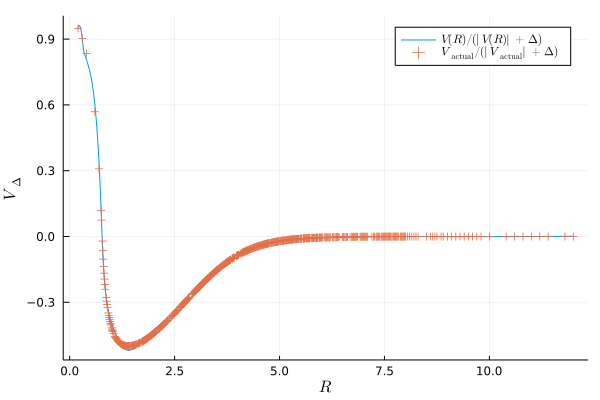

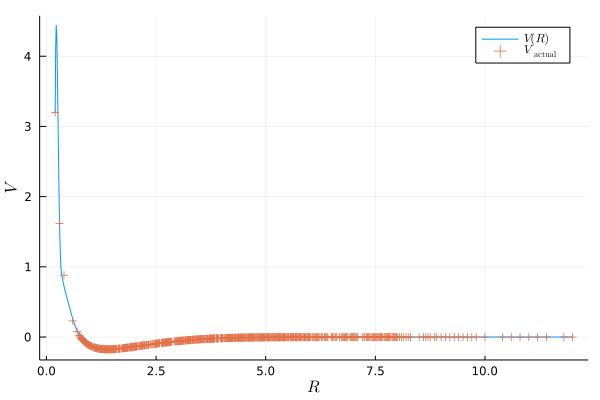

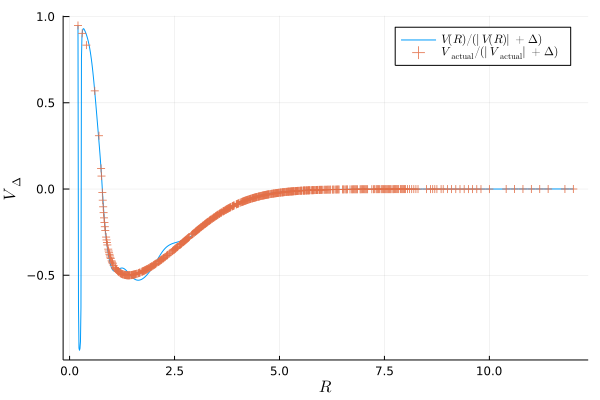

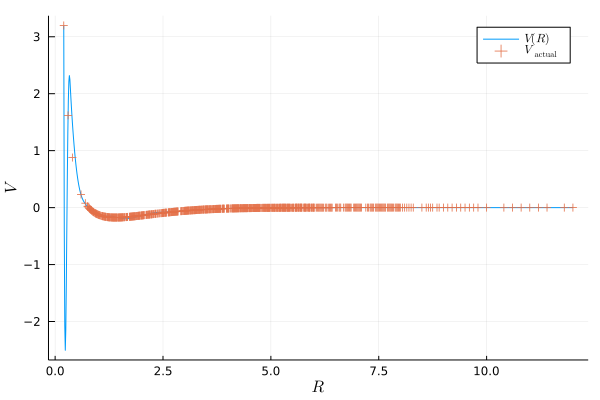

\mathrm{power} = 1$, $a \mathrm{RMSE} = 0.002568706315936644$: undefined symbol
\mathrm{power} = 1$, $a \mathrm{RMSE} = 0.002568706315936644$: undefined symbol
\mathrm{power} = 1$, $a \mathrm{RMSE} = 0.002568706315936644$: undefined symbol
\mathrm{power} = 1$, $\mathrm{RMSE} = 0.007795972969796085$: undefined symbol
\mathrm{power} = 1$, $\mathrm{RMSE} = 0.007795972969796085$: undefined symbol
\mathrm{power} = 1$, $\mathrm{RMSE} = 0.007795972969796085$: undefined symbol
\mathrm{power} = 6$, $a \mathrm{RMSE} = 0.005759902894781382$: undefined symbol
\mathrm{power} = 6$, $a \mathrm{RMSE} = 0.005759902894781382$: undefined symbol
\mathrm{power} = 6$, $a \mathrm{RMSE} = 0.005759902894781382$: undefined symbol
\mathrm{power} = 6$, $\mathrm{RMSE} = 0.027931804905988563$: undefined symbol
\mathrm{power} = 6$, $\mathrm{RMSE} = 0.027931804905988563$: undefined symbol
\mathrm{power} = 6$, $\mathrm{RMSE} = 0.027931804905988563$: undefined symbol


In [32]:
plot_error()

### test ratpot(s) any:

In [629]:
H_data = readdlm("data/h2/h2_ground_w.txt")
R = H_data[:, 1]; V = H_data[:, 2]
siz = size(R)[1]

670

In [ ]:
idxes = shuffleobs(1:siz) # shuffle indexes
id_train, id_test = splitobs(idxes, at=0.8)
writedlm("data/diatomic/index_train_H2.csv", id_train)
writedlm("data/diatomic/index_test_H2.csv", id_test)

In [630]:
id_train = vec(readdlm("data/diatomic/index_train_H2.csv", Int))
id_test = vec(readdlm("data/diatomic/index_test_H2.csv", Int))
R_train = R[id_train]; V_train = V[id_train];
R_test = R[id_test]; V_test = V[id_test];

#### ratpot1:

In [79]:
M = 13; Z = 1;
ub = 1.; lb = -1.
θ = rand(3*M+1) .* (ub-lb) .+ lb # random between [a, b] = [-1, 1]
f_least_squares(f_ratpot_1, V_train, θ, R_train, Z, M)

547.8563648997737

In [80]:
res = optimize(θ -> f_least_squares(f_ratpot_1, V_train, θ, R_train, Z, M),
                θ, BFGS(),
                Optim.Options(iterations = 2000, show_trace=false); 
                autodiff = :forward
                )
#res = LsqFit.curve_fit((R_train, θ) -> f_ratpot_1(θ, R_train, Z, M), R_train, V_train, θ, show_trace=false, maxIter=2000)

 * Status: success

 * Candidate solution
    Final objective value:     1.572561e-09

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 7.41e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.89e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-18 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.41e-09 ≰ 0.0e+00
    |g(x)|                 = 5.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    874
    f(x) calls:    2369
    ∇f(x) calls:   2369


In [81]:
# check RMSE:
V_pred = f_ratpot_1(res.minimizer, R_train, Z, M)
println(f_RMSE(V_train, V_pred))
V_pred = f_ratpot_1(res.minimizer, R_test, Z, M)
println(f_RMSE(V_test, V_pred))
for i=1:length(V_test)
    println(V_pred[i]," ",V_test[i])
end

1.712857984945949e-6
2.1144972160561683e-6
-0.06579924991320772 -0.06579983
-0.005676879079616565 -0.005678854999999983
-0.00046126570774393674 -0.0004605310000000973
-0.05487036522626821 -0.05487149000000002
-0.0001678511698747813 -0.00017016300000016749
-0.0735669222373039 -0.07356698900000014
-0.11474201150117778 -0.11474186600000014
-0.15506589964569267 -0.15506615300000015
-0.06737171482410602 -0.06737306499999995
-0.0003063243541384562 -0.00030691700000007316
-0.014859871995083828 -0.014859248000000047
-0.01424476199526409 -0.014244327999999973
-0.0013717744583323698 -0.0013695510000000244
-0.0045324823040952976 -0.004534004000000147
-0.06113896252977485 -0.06113983000000012
-0.14340528221733143 -0.14340553500000008
0.23038029323663464 0.23036719299999997
-0.005035476492813402 -0.005037254999999963
-0.00859909108197855 -0.008600756999999959
-0.005937224743574035 -0.005939244000000121
-0.15021136943614508 -0.150211624
-0.1558484102525061 -0.155848663
-2.9401507780324866e-5 -3.1338

#### test tchebyshev ratpot

In [502]:
const_r_xy = 1.4172946 # H2
#const_r_xy = 1.9369 #OH+
max_tcheb_deg = 11; k = 6

# for plotting:
idx = sortperm(R_train)
R_eq = collect(LinRange(minimum(R_train), maximum(R_train), Int(2e3)))
ρ_eq = f_ρ(R_eq, const_r_xy)
q_eq = f_q(ρ_eq)
p_pol_eq = f_tcheb_u(q_eq, max_tcheb_deg)
p_pol_eq = hcat(ones(size(p_pol_eq)[1]), p_pol_eq)
ρ_scaler_eq = ((ρ_eq .+ ρ_eq).^k)

# dissociation of energy:
V_min = minimum(V)
V_l = V[argmax(R)]
Δ = V_l - V_min
ΔV_train = f_ΔV(V_train, V_l, V_min)
V_train_dis = V_train ./ ΔV_train

# one-time computations, train data:
ρ = f_ρ(R_train, const_r_xy)
q = f_q(ρ)
p_pol = f_tcheb_u(q, max_tcheb_deg)
p_pol = hcat(ones(size(p_pol)[1]), p_pol) # p₀ = 1 as the first entry
ρ_scaler = ((ρ .+ ρ).^k)

# test data:
ρ_t = f_ρ(R_test, const_r_xy)
q_t = f_q(ρ_t)
p_pol_t = f_tcheb_u(q_t, max_tcheb_deg)
p_pol_t = hcat(ones(size(p_pol_t)[1]), p_pol_t)
ρ_scaler_t = ((ρ_t .+ ρ_t).^k);

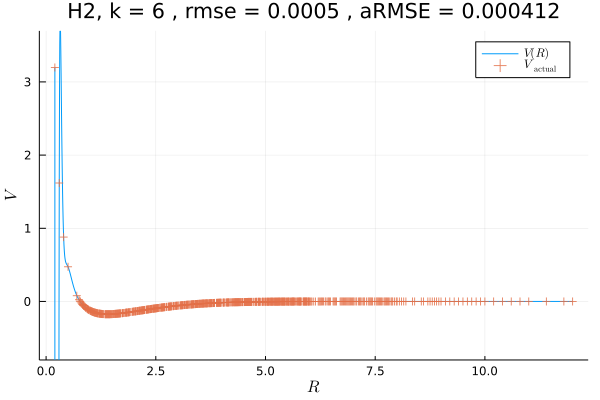

train RMSE = 0.0004998372455621321
train aRMSE = 0.000411897528159249
test RMSE = 0.0027266249944016786


In [508]:
# default scaling, V = u/ρ:
p_pol_scaled = p_pol ./ ρ_scaler
θ = p_pol_scaled\V_train; # linear solve
V_pred = p_pol_scaled*θ # prediction
rmse = f_RMSE(V_pred, V_train)
println("train RMSE = ",rmse)
# aRMSE:
ΔV = f_ΔV(V_pred, V_l, V_min)
δ = δ_dissociate(V_train, V_pred, ΔV)
a_rmse = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
println("train aRMSE = ",a_rmse)
# test data:
p_pol_scaled_t = p_pol_t ./ ρ_scaler_t
V_pred = p_pol_scaled_t*θ # prediction
println("test RMSE = ", f_RMSE(V_pred, V_test))
# plot:

p_pol_eq_scaled = p_pol_eq ./ ρ_scaler_eq
V_eq = p_pol_eq_scaled*θ # V(R_eq)
display(plot([R_eq, R_train[idx]], [V_eq, V_train[idx]],
                xlabel = L"$R$", ylabel = L"$V$",
                #title = L"H2, $\mathrm{power} = %$k$",
                title = "H2, k = "*string(k)*" , rmse = "*string(round(rmse, digits=6))*" , aRMSE = "*string(round(a_rmse, digits=6)),
                label = [L"$V(R)$" L"$V_\mathrm{actual}$"],
                seriestype = [:line :scatter], markershape=[:none :+],
                fmt = :png, ylims=(-.8, maximum(V_train)+0.5))
                )

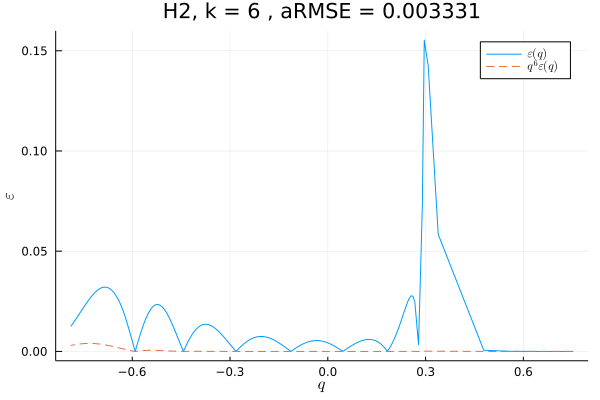

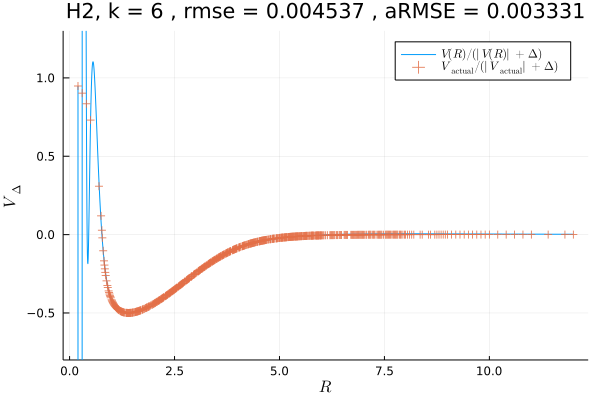

train RMSE = 0.004536504889225808
train aRMSE = 0.0033314891831868424


In [504]:
## dissociated energy:
θ = p_pol_scaled\V_train_dis # scale this with p_Δ?? since p:=V(R)
V_pred = p_pol_scaled*θ
rmse = f_RMSE(V_pred, V_train_dis)
println("train RMSE = ",rmse)
## aRMSE:
ΔV = f_ΔV(V_pred, V_l, V_min)
δ = δ_dissociate(V_train_dis, V_pred, ΔV)
a_rmse = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
println("train aRMSE = ",a_rmse)

## plot:
ϵ = abs.(δ)
ϵ_pow = (q .^ 6) .*ϵ

display(plot(q[idx], [ϵ[idx], ϵ_pow[idx]], 
        xlabel = L"$q$", ylabel = L"$\epsilon$", 
        title = "H2, k = "*string(k)*" , aRMSE = "*string(round(a_rmse, digits=6)), 
        label = [L"$ \epsilon (q)$" L"$q^6 \epsilon (q)$"], 
        linestyles = [:solid :auto],
        fmt = :png))

p_pol_eq_scaled = p_pol_eq ./ ρ_scaler_eq
V_eq = p_pol_eq_scaled*θ # V(R_eq)
ΔV_eq = f_ΔV(V_eq, V_l, V_min)
V_eq_dis = V_eq ./ ΔV_eq # V_diss(R_eq)
display(plot([R_eq, R_train[idx]], [V_eq, V_train_dis[idx]],
                xlabel = L"$R$", ylabel = L"$V_\Delta$",
                #title = L"H2, $\mathrm{power} = %$k$, $\mathrm{aRMSE} = %$a_rmse$",
                title = "H2, k = "*string(k)*" , rmse = "*string(round(rmse, digits=6))*" , aRMSE = "*string(round(a_rmse, digits=6)),
                label = [L"$V(R)/(|V(R)| + \Delta)$" L"$V_\mathrm{actual}/(|V_\mathrm{actual}| + \Delta)$"],
                seriestype = [:line :scatter], markershape=[:none :+],
                fmt = :png, ylims = (-.8, 1.3))
                )

In [356]:
# scale mode (1), Vρ = u:
V_ρ = V_train .* ρ_scaler # scale V by ρ + ρ^k
θ = p_pol\V_ρ; # linear solve
V_pred = p_pol*θ # prediction
display(f_RMSE(V_pred, V_ρ))
# test data:
V_ρ_t = V_test .* ρ_scaler_t
V_pred = p_pol_t*θ
display(f_RMSE(V_pred, V_ρ_t))

0.00019308345751965436

0.00018797327012475446

In [357]:
# scale mode (2), part(ρ)V=u/part(ρ):
V_ρ = V_train .* ρ # scale V by ρ
p_pol_scaled = p_pol ./ (1 .+ ρ.^(k-1)) # scale 1/u by 1 + ρ^(k-1)
θ = p_pol_scaled\V_ρ # linear solve
V_pred = p_pol_scaled*θ # prediction
display(f_RMSE(V_pred, V_ρ))
# test data:
V_ρ_t = V_test .* ρ_t
p_pol_scaled_t = p_pol_t ./ (1 .+ ρ_t.^(k-1))
V_pred = p_pol_scaled_t*θ
display(f_RMSE(V_pred, V_ρ_t))

9.654172875982718e-5

9.398663506237723e-5

#### val on [:5] and [:end-5] data points, get best $d$

In [175]:
H_data = readdlm("data/h2/h2_ground_w.txt")
R = H_data[:, 1]; V = H_data[:, 2]
siz = size(R)[1]
id_train = 6:siz-5
id_test = vcat(1:5, siz-4:siz)
R_train = R[id_train]; V_train = V[id_train];
R_test = R[id_test]; V_test = V[id_test];
const_r_xy = 1.4172946 # H2, possibility: multiplicity of this, 2*const_r_xy, etc
#const_r_xy = 1.9369 #OH+

1.4172946

In [618]:
# dissociation of energy:
## train:
V_min = minimum(V)
V_l = V[argmax(R)]
Δ = V_l - V_min
ΔV_train = f_ΔV(V_train, V_l, V_min)
V_train_dis = V_train ./ ΔV_train

## test:
V_min = minimum(V)
V_l = V[argmax(R)]
Δ = V_l - V_min
ΔV_test = f_ΔV(V_test, V_l, V_min)
V_test_dis = V_test ./ ΔV_test

# one-time computations, train data:
ρ = f_ρ(R_train, const_r_xy)
q = f_q(ρ)

# test data:
ρ_t = f_ρ(R_test, const_r_xy)
q_t = f_q(ρ_t)

list_k = [1, 6]
list_d = 1:30
list_best_a_rmse = [] # each entry belongs to each k
list_best_d = [] # each entry belongs to each k

# dissociated energy:
list_best_a_rmse_dis = []
list_best_d_dis = []

for k = list_k
    min_a_rmse = Inf
    min_a_rmse_dis = Inf
    best_d = best_d_dis = 0
    for d = list_d
        println("k = ",k, ", d =",d)
        # one-timer, train data:
        p_pol = f_tcheb_u(q, d)
        p_pol = hcat(ones(size(p_pol)[1]), p_pol) # p₀ = 1 as the first entry
        ρ_scaler = ((ρ .+ ρ).^k)
        # one-timer, val data:
        p_pol_t = f_tcheb_u(q_t, d)
        p_pol_t = hcat(ones(size(p_pol_t)[1]), p_pol_t)
        ρ_scaler_t = ((ρ_t .+ ρ_t).^k);

        # non diss:
        ## RMSE train:
        p_pol_scaled = p_pol ./ ρ_scaler
        θ = p_pol_scaled\V_train; # linear solve
        V_pred = p_pol_scaled*θ # prediction
        rmse = f_RMSE(V_pred, V_train)
        ## aRMSE train:
        ΔV = f_ΔV(V_pred, V_l, V_min)
        δ = δ_dissociate(V_train, V_pred, ΔV)
        a_rmse = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
        ## RMSE test:
        p_pol_scaled_t = p_pol_t ./ ρ_scaler_t
        V_pred = p_pol_scaled_t*θ # prediction
        rmse = f_RMSE(V_pred, V_test)
        println("val RMSE = ", rmse)
        ## aRMSE test:
        ΔV = f_ΔV(V_pred, V_l, V_min)
        δ = δ_dissociate(V_test, V_pred, ΔV)
        a_rmse_val = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
        println("val aRMSE = ",a_rmse_val)
        if a_rmse_val < min_a_rmse
            min_a_rmse = a_rmse_val
            best_d = d
            println(d)
        end
        
        # dissdata:
        ## RMSE train:
        θ = p_pol_scaled\V_train_dis
        V_pred = p_pol_scaled*θ
        rmse_dis = f_RMSE(V_pred, V_train_dis)
        println("train RMSE dis = ",rmse_dis)
        ## aRMSE train:
        ΔV = f_ΔV(V_pred, V_l, V_min)
        δ = δ_dissociate(V_train_dis, V_pred, ΔV)
        a_rmse_dis = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
        println("train aRMSE dis = ",a_rmse_dis)
        ## RMSE val:
        θ = p_pol_scaled_t\V_test_dis
        V_pred = p_pol_scaled_t*θ
        rmse_dis_val = f_RMSE(V_pred, V_test_dis)
        println("val RMSE dis = ",rmse_dis_val)
        ## aRMSE val:
        ΔV = f_ΔV(V_pred, V_l, V_min)
        δ = δ_dissociate(V_test_dis, V_pred, ΔV)
        a_rmse_dis_val = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
        println("val aRMSE dis = ",a_rmse_dis_val)
        
        if a_rmse_dis_val < min_a_rmse_dis
            min_a_rmse_dis = a_rmse_dis_val
            best_d_dis = d
            println(d)
        end
        
    end
    push!(list_best_a_rmse, min_a_rmse)
    push!(list_best_a_rmse_dis, min_a_rmse_dis)
    push!(list_best_d, best_d)
    push!(list_best_d_dis, best_d_dis)
end
display(list_best_a_rmse)
display(list_best_d)
display(list_best_a_rmse_dis)
display(list_best_d_dis)

k = 1, d =1
val RMSE = 1.3807404117111572
val aRMSE = 0.42879681577206746
1
train RMSE dis = 0.1248564330162975
train aRMSE dis = 0.05574297491762981
val RMSE dis = 0.074815139304738
val aRMSE dis = 0.0406514894818542
1
k = 1, d =2
val RMSE = 0.2888985430802074
val aRMSE = 0.021173468999379625
2
train RMSE dis = 0.02481889859398034
train aRMSE dis = 0.016464114665579045
val RMSE dis = 0.02837942283854853
val aRMSE dis = 0.0073740809254476845
2
k = 1, d =3
val RMSE = 1.1989703329561754
val aRMSE = 0.04869184251831498
train RMSE dis = 0.024429716542872067
train aRMSE dis = 0.015335842904192178
val RMSE dis = 0.015320832541641793
val aRMSE dis = 0.002997791668316868
3
k = 1, d =4
val RMSE = 1.5654637254314359
val aRMSE = 0.5306086545443663
train RMSE dis = 0.02184448976762469
train aRMSE dis = 0.012562468111680708
val RMSE dis = 0.005269947006189578
val aRMSE dis = 0.004026176752991449
k = 1, d =5
val RMSE = 0.511338308875526
val aRMSE = 0.054628762091799274
train RMSE dis = 0.00785538943

val RMSE = 3.0992476526484634e6
val aRMSE = 0.1172978748480829
train RMSE dis = 0.00025453594233363367
train aRMSE dis = 0.00016706627462382862
val RMSE dis = 3.7073249262069787e-14
val aRMSE dis = 1.1559838895402008e-14
18
k = 6, d =19
val RMSE = 227938.05179983095
val aRMSE = 0.11141441065658084
train RMSE dis = 0.0002609076897290767
train aRMSE dis = 0.0001744918049426571
val RMSE dis = 1.6152989097428554e-14
val aRMSE dis = 7.357608270673215e-15
19
k = 6, d =20
val RMSE = 88849.49800123918
val aRMSE = 0.11170600145134937
train RMSE dis = 0.0002692926497011259
train aRMSE dis = 0.00018256269176827736
val RMSE dis = 3.5549567703944156e-14
val aRMSE dis = 2.2443817219029355e-14
k = 6, d =21
val RMSE = 335463.86636552436
val aRMSE = 0.12758453154169627
train RMSE dis = 0.00026146313597135996
train aRMSE dis = 0.00017873021773456686
val RMSE dis = 4.356835533983589e-14
val aRMSE dis = 1.2242927964639558e-14
k = 6, d =22
val RMSE = 13054.189650167467
val aRMSE = 0.11655269400468714
train

2-element Vector{Any}:
 0.021173468999379625
 0.09362768516580992

2-element Vector{Any}:
  2
 25

2-element Vector{Any}:
 8.700240999948389e-15
 7.357608270673215e-15

2-element Vector{Any}:
  9
 19

val RMSE = 223.68920256990594
val aRMSE = 0.14722760819387282
train RMSE dis = 0.13215607992253298
train aRMSE dis = 0.1058114938303733
val RMSE dis = 8.023646672570646e-9
val aRMSE dis = 8.001536142139628e-9


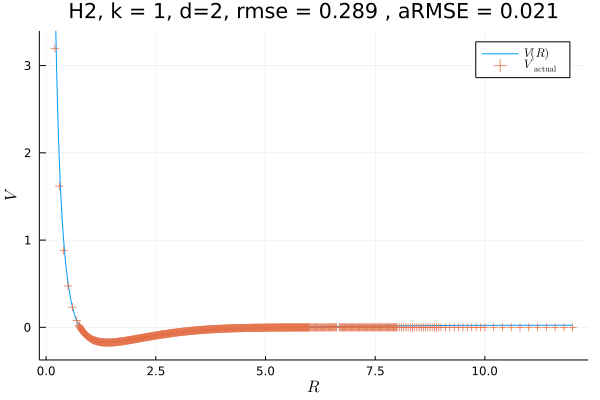

train RMSE = 0.010368887047138495
train aRMSE = 0.008696665753132013
val RMSE = 0.2888985430802074
val aRMSE = 0.021173468999379625


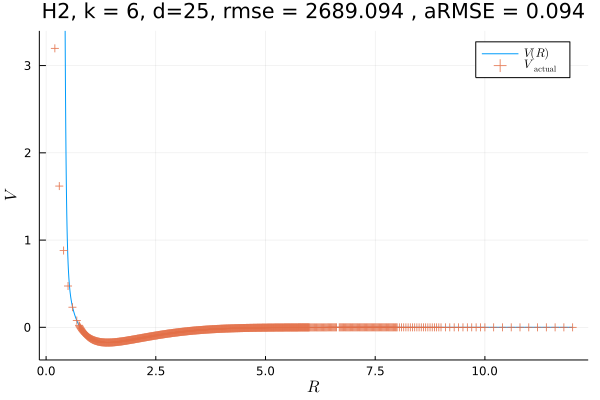

train RMSE = 1.7127217777003076e-6
train aRMSE = 1.4637191079948608e-6
val RMSE = 2689.0943883787186
val aRMSE = 0.09362768516580992


In [619]:
# Non-diss data:
# plot best d for each k=1,6:
# one-timer, train data:
for i = 1:length(list_k)
    d = list_best_d[i]; k = list_k[i]
    
    p_pol = f_tcheb_u(q, d)
    p_pol = hcat(ones(size(p_pol)[1]), p_pol) # p₀ = 1 as the first entry
    ρ_scaler = ((ρ .+ ρ).^k)

    # one-timer, val data:
    p_pol_t = f_tcheb_u(q_t, d)
    p_pol_t = hcat(ones(size(p_pol_t)[1]), p_pol_t)
    ρ_scaler_t = ((ρ_t .+ ρ_t).^k);

    # default scaling, V = u/ρ:
    p_pol_scaled = p_pol ./ ρ_scaler
    θ = p_pol_scaled\V_train; # linear solve
    V_pred = p_pol_scaled*θ # prediction
    rmse = f_RMSE(V_pred, V_train)
    println("train RMSE = ",rmse)
    ## aRMSE:
    ΔV = f_ΔV(V_pred, V_l, V_min)
    δ = δ_dissociate(V_train, V_pred, ΔV)
    a_rmse = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
    println("train aRMSE = ",a_rmse)

    # val data:
    p_pol_scaled_t = p_pol_t ./ ρ_scaler_t
    V_pred = p_pol_scaled_t*θ # prediction
    rmse_test = f_RMSE(V_pred, V_test)
    println("val RMSE = ", rmse_test)
    ## aRMSE:
    ΔV = f_ΔV(V_pred, V_l, V_min)
    δ = δ_dissociate(V_test, V_pred, ΔV)
    a_rmse_test = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
    println("val aRMSE = ",a_rmse_test)


    # plot:
    # for plotting:
    idx = sortperm(R)
    R_eq = collect(LinRange(minimum(R), maximum(R), Int(2e3)))
    ρ_eq = f_ρ(R_eq, const_r_xy)
    q_eq = f_q(ρ_eq)
    p_pol_eq = f_tcheb_u(q_eq, d)
    p_pol_eq = hcat(ones(size(p_pol_eq)[1]), p_pol_eq)
    ρ_scaler_eq = ((ρ_eq .+ ρ_eq).^k)

    p_pol_eq_scaled = p_pol_eq ./ ρ_scaler_eq
    V_eq = p_pol_eq_scaled*θ # V(R_eq)
    display(plot([R_eq, R[idx]], [V_eq, V[idx]],
                    xlabel = L"$R$", ylabel = L"$V$",
                    #title = L"H2, $\mathrm{power} = %$k$",
                    title = "H2, k = "*string(k)*", d="*string(d)*", rmse = "*string(round(rmse_test, digits=3))*" , aRMSE = "*string(round(a_rmse_test, digits=3)),
                    label = [L"$V(R)$" L"$V_\mathrm{actual}$"],
                    seriestype = [:line :scatter], markershape=[:none :+],
                    fmt = :png, ylims=(minimum(V)-0.2, maximum(V)+0.2))
                    )
end

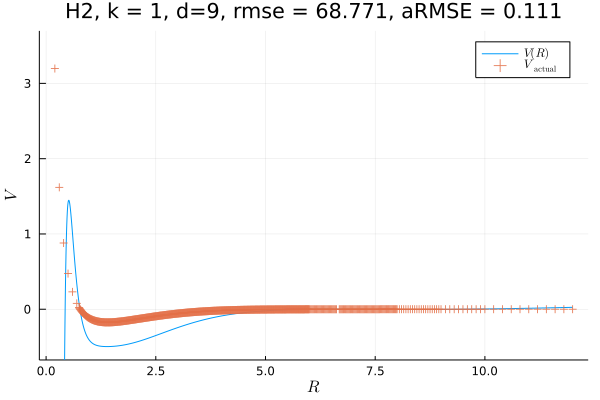

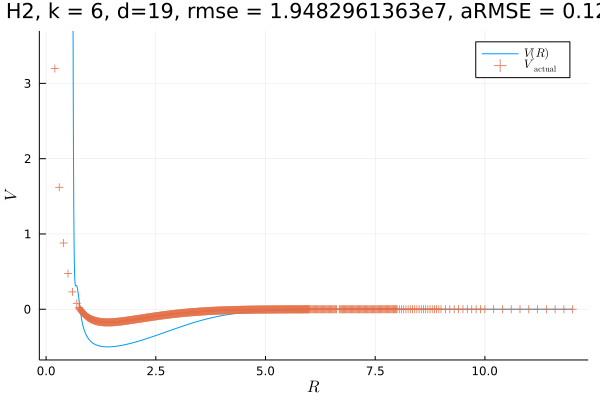

train RMSE = 0.0036477036990474666
train aRMSE = 0.0024452314307039026
val RMSE = 68.7712372908213
val aRMSE = 0.11053798637155521
train RMSE = 0.0002609076897290767
train aRMSE = 0.0001744918049426571
val RMSE = 1.948296136336292e7
val aRMSE = 0.12145222315073591


In [620]:
# Diss data:
# plot best d for each k=1,6:
# one-timer, train data:
for i = 1:length(list_k)
    d = list_best_d_dis[i]; k = list_k[i]
    
    p_pol = f_tcheb_u(q, d)
    p_pol = hcat(ones(size(p_pol)[1]), p_pol) # p₀ = 1 as the first entry
    ρ_scaler = ((ρ .+ ρ).^k)

    # one-timer, val data:
    p_pol_t = f_tcheb_u(q_t, d)
    p_pol_t = hcat(ones(size(p_pol_t)[1]), p_pol_t)
    ρ_scaler_t = ((ρ_t .+ ρ_t).^k);

    # default scaling, V = u/ρ:
    p_pol_scaled = p_pol ./ ρ_scaler
    θ = p_pol_scaled\V_train_dis; # linear solve
    V_pred = p_pol_scaled*θ # prediction
    rmse = f_RMSE(V_pred, V_train_dis)
    println("train RMSE = ",rmse)
    ## aRMSE:
    ΔV = f_ΔV(V_pred, V_l, V_min)
    δ = δ_dissociate(V_train_dis, V_pred, ΔV)
    a_rmse = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
    println("train aRMSE = ",a_rmse)

    # val data:
    p_pol_scaled_t = p_pol_t ./ ρ_scaler_t
    V_pred = p_pol_scaled_t*θ # prediction
    rmse_test = f_RMSE(V_pred, V_test_dis)
    println("val RMSE = ", rmse_test)
    ## aRMSE:
    ΔV = f_ΔV(V_pred, V_l, V_min)
    δ = δ_dissociate(V_test_dis, V_pred, ΔV)
    a_rmse_test = Δ*f_RMSE(δ) # adjusted RMSE, Δ = V_l-V_min above
    println("val aRMSE = ",a_rmse_test)


    # plot:
    # for plotting:
    idx = sortperm(R)
    R_eq = collect(LinRange(minimum(R), maximum(R), Int(2e3)))
    ρ_eq = f_ρ(R_eq, const_r_xy)
    q_eq = f_q(ρ_eq)
    p_pol_eq = f_tcheb_u(q_eq, d)
    p_pol_eq = hcat(ones(size(p_pol_eq)[1]), p_pol_eq)
    ρ_scaler_eq = ((ρ_eq .+ ρ_eq).^k)

    
    p_pol_eq_scaled = p_pol_eq ./ ρ_scaler_eq
    V_eq = p_pol_eq_scaled*θ # V(R_eq)
    ΔV_eq = f_ΔV(V_eq, V_l, V_min)
    V_eq_dis = V_eq ./ ΔV_eq # V_diss(R_eq)
    
    display(plot([R_eq, R[idx]], [V_eq, V[idx]],
                    xlabel = L"$R$", ylabel = L"$V$",
                    #title = L"H2, $\mathrm{power} = %$k$",
                    title = "H2, k = "*string(k)*", d="*string(d)*", rmse = "*string(round(rmse_test, digits=3))*", aRMSE = "*string(round(a_rmse_test, digits=3)),
                    label = [L"$V(R)$" L"$V_\mathrm{actual}$"],
                    seriestype = [:line :scatter], markershape=[:none :+],
                    fmt = :png, ylims=(minimum(V)-0.5, maximum(V)+0.5))
                    )
end

#### empirical power law on data

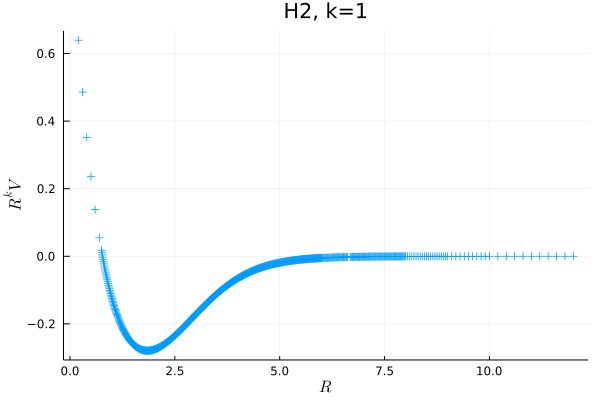

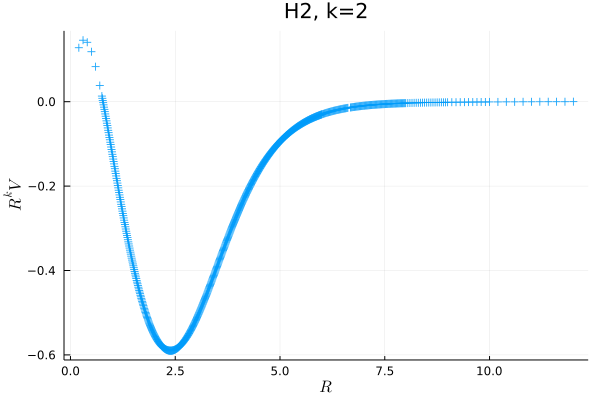

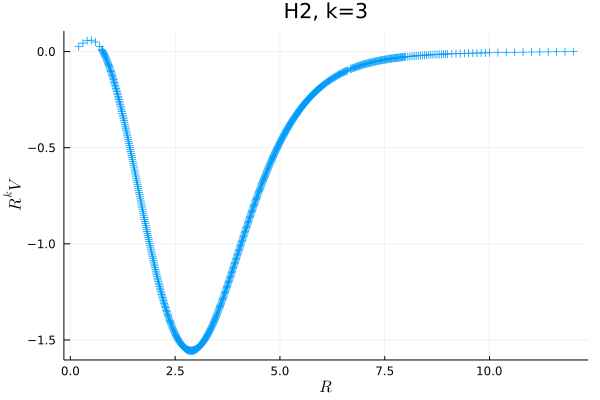

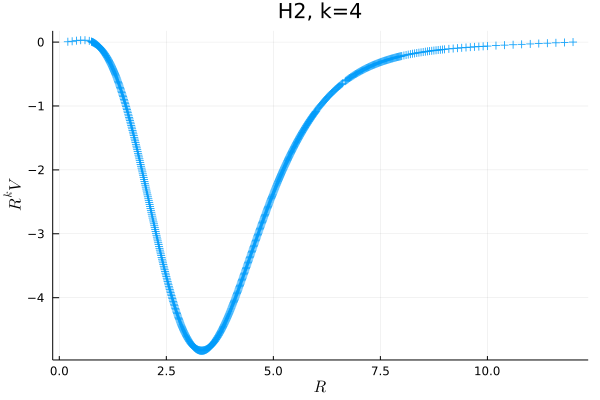

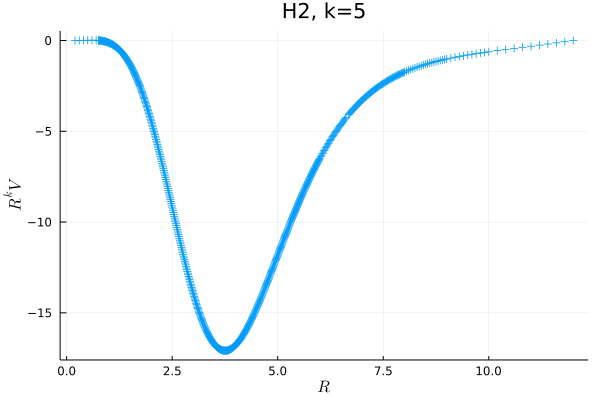

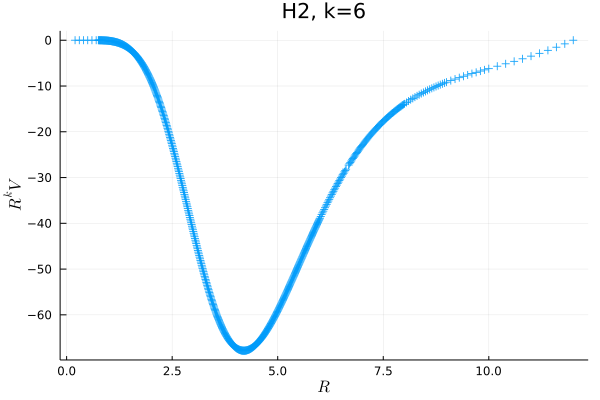

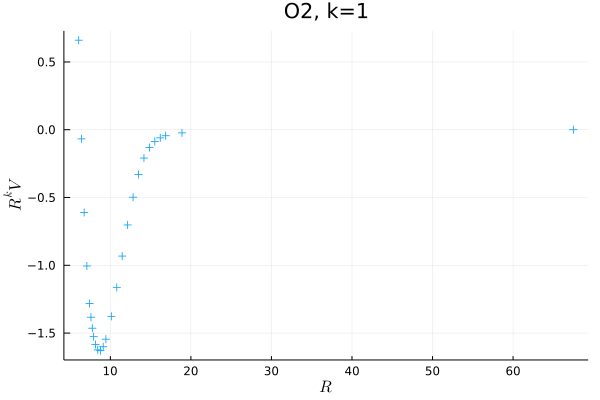

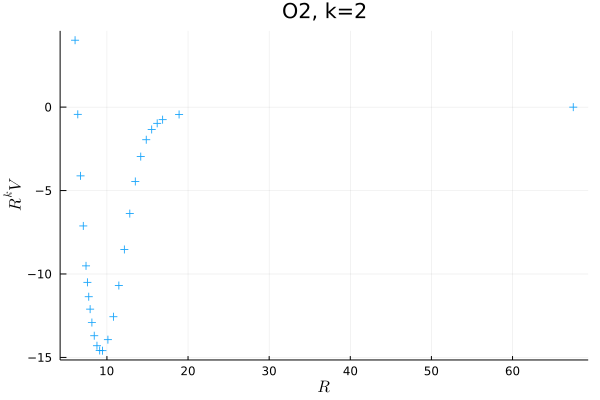

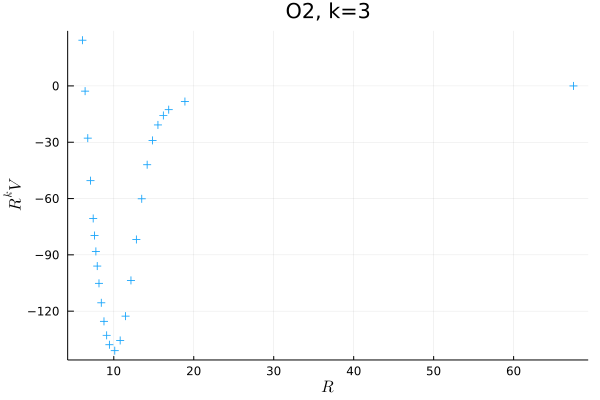

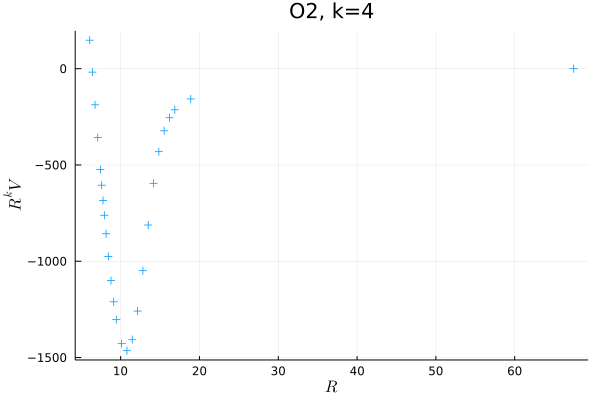

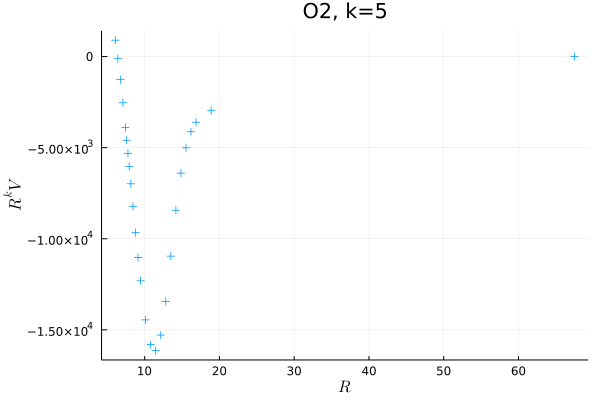

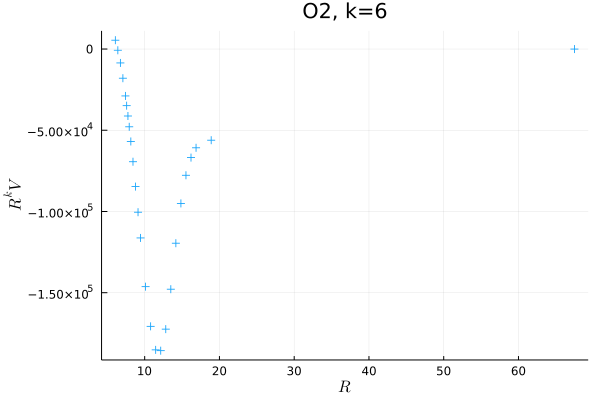

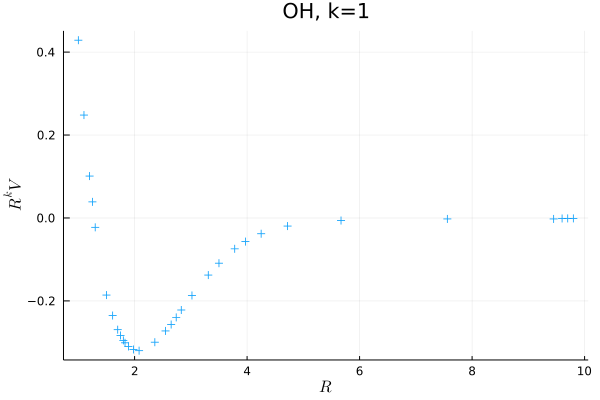

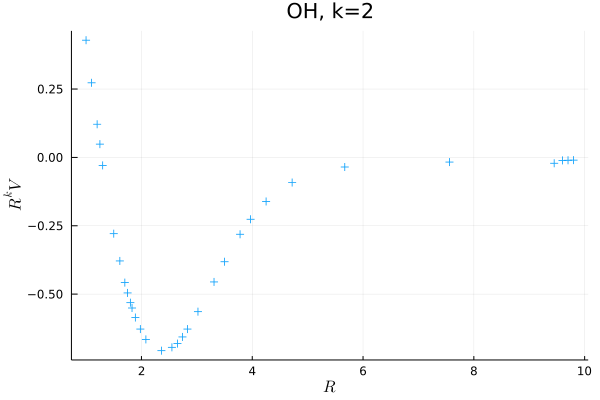

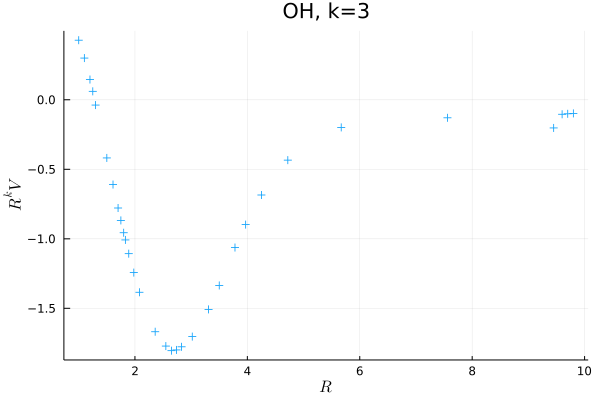

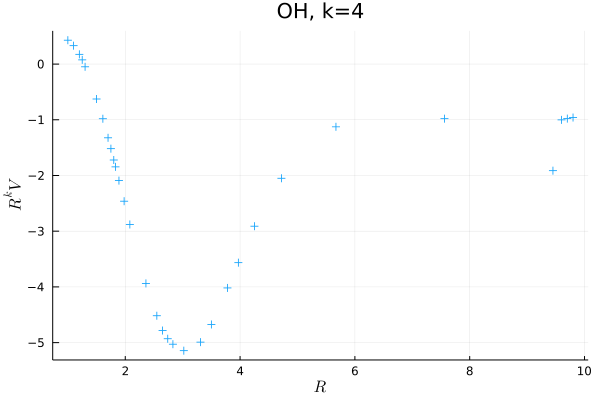

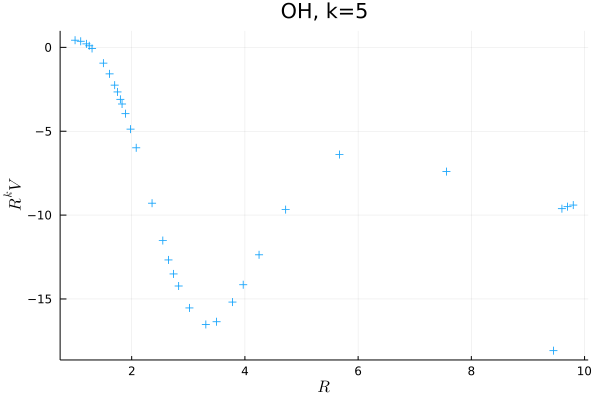

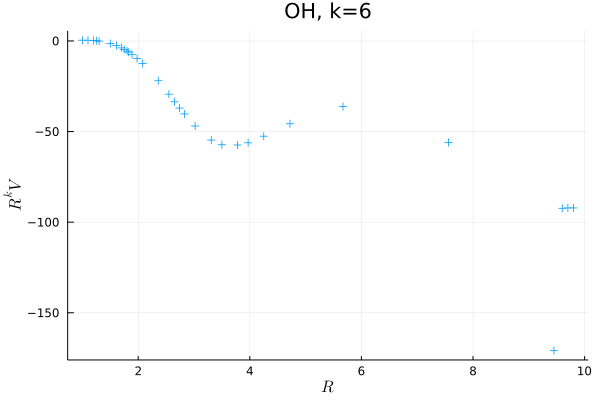

In [628]:
# r^k V(r) for k=1:6
R_mat = Matrix{Float64}(undef, length(R), 6)
filenames = ["data/diatomic/h2_ground_w.txt", "data/diatomic/o2_data.txt", "data/diatomic/oh_data.txt"]
mol = ["H2", "O2", "OH"]
for i ∈ 1:length(mol)
    H_data = readdlm(filenames[i])
    R = H_data[:, 1]; V = H_data[:, 2]
    for k=1:6
        display(plot(R, (R.^k) .* V, 
                xlabel = L"$R$", ylabel = L"$R^kV$", title = mol[i]*", k="*string(k),
                seriestype = :scatter, markershape = :+, label="k="*string(k), legend = :none,
                fmt = :png))
    end
end
